In [1]:
include("src/simulation_lightning.jl")
using .simulation_lightning
using BenchmarkTools, Combinatorics, DataStructures, LaTeXStrings, SpecialFunctions, Printf, ImageFiltering, OffsetArrays, StatsBase
import PyPlot
const plt = PyPlot

PyPlot

In [2]:
function simulation(dict_genenotype2index, G, Freq_host, Freq_phage, args, T; del_old = true, stop = true)
    
    TimeSeries_genotype_host, TimeSeries_genotype_phage= [], []
    
    TimeSeries_gene_host, TimeSeries_gene_phage= [], []
    
    TimeSeries_outflow_host, TimeSeries_inflow_host= [], []
    
    TimeSeries_outflow_phage, TimeSeries_inflow_phage= [], []
    
    count_3body =[]
    
    FreqG_outflow_host = [1, 1]
    FreqG_inflow_host = [1, 1] 
    FreqG_outflow_phage = [1, 1]
    FreqG_inflow_phage = [1, 1]
    for t in 1:T
    	NX = sum(Freq_host)
    	if args["rR_random"] != 0
    		G_host_new, FreqG_outflow_host, FreqG_inflow_host = recombination_random(dict_genenotype2index, G, Freq_host, args["L"], args["rR_random"], NX,del_old = del_old) 
        end

        if args["rR_hosthost"] != 0
        	G_host_new, FreqG_outflow_host, FreqG_inflow_host  = recombination(dict_genenotype2index, G, Freq_host, args["L"], args["rR_hosthost"], NX, del_old = del_old) 
        end 


        NY = sum(Freq_phage)
        if args["rH_random"] != 0
            G_phage_new, FreqG_outflow_phage, FreqG_inflow_phage = recombination_random(dict_genenotype2index, G, Freq_phage, args["L"], args["rH_random"], NY,del_old = del_old) 
        end
        if args["rH_phagephage"] != 0
            G_phage_new, FreqG_outflow_phage, FreqG_inflow_phage = recombination(dict_genenotype2index, G, Freq_phage, args["L"], args["rH_phagephage"], NY,del_old = del_old) 
        end
        if args["rH_phagehost"] != 0
            G_phage_new, FreqG_outflow_phage, FreqG_inflow_phage = HorizontalGeneTransfer_2body(dict_genenotype2index, G, Freq_host, Freq_phage, args["L"], args["rH_phagehost"], NY,del_old = del_old)
        end
        if args["rH_3body"] != 0
            G_phage_new, G_phage_sampled = HorizontalGeneTransfer_3body_ImportantSampling(dict_genenotype2index, G, Freq_host, Freq_phage, args["L"], args["rH_3body"], NY)
        end

        FreqG_outflow_host = [1, 1]
        FreqG_inflow_host = [1, 1] 
        FreqG_outflow_phage = [1, 1]
        FreqG_inflow_phage = [1, 1] 
        
        push!(TimeSeries_outflow_host, copy(FreqG_outflow_host))
        push!(TimeSeries_inflow_host, copy(FreqG_inflow_host))
        push!(TimeSeries_outflow_phage, copy(FreqG_outflow_phage))
        push!(TimeSeries_inflow_phage, copy(FreqG_inflow_phage))
        
        if args["population_constraint"] =="hard"
			Fit_host, Fit_phage = cal_fitness_hard_constraint(Freq_host, Freq_phage, args["J"], args["Jprop"]*args["J"])
			Freq_host, meanfit_host = select_hard_constraint(Freq_host, Fit_host, args["NX"])
			Freq_phage, meanfit_phage = select_hard_constraint(Freq_phage, Fit_phage, args["NY"])

		elseif args["population_constraint"] =="soft"
			Fit_host, Fit_phage = cal_fitness_no_constraint(Freq_host, Freq_phage, args["J"], args["J"]*args["Jprop"], args["NX"], args["NY"])
        	
            Freq_host, meanfit_host = select_soft_constraint(Freq_host, Fit_host, 10*args["NX"])
        
        	Freq_phage, meanfit_phage = select_soft_constraint(Freq_phage, Fit_phage, 10*args["NY"])

		elseif args["population_constraint"] =="no"
			Fit_host, Fit_phage = cal_fitness_no_constraint(Freq_host, Freq_phage, args["J"], args["J"]*args["Jprop"], args["NX"], args["NY"])
        	Freq_host, meanfit_host = select_no_constraint(Freq_host, Fit_host)
        
        	Freq_phage, meanfit_phage = select_no_constraint(Freq_phage, Fit_phage)
        elseif args["population_constraint"] =="host_hard"
			Fit_host, Fit_phage = cal_fitness_no_constraint(Freq_host, Freq_phage, args["J"], args["J"]*args["Jprop"], args["NX"], args["NY"])
            Freq_host, meanfit_host = select_hard_constraint(Freq_host, Fit_host, args["NX"])
        	Freq_phage, meanfit_phage = select_no_constraint(Freq_phage, Fit_phage)
            
        elseif args["population_constraint"] =="mixed"
			Fit_host, Fit_phage = cal_fitness_no_constraint(Freq_host, Freq_phage, args["J"], args["J"]*args["Jprop"], args["NX"], args["NY"])
            
        	Freq_host, meanfit_host = select_hard_constraint(Freq_host, Fit_host, args["NX"])
        
        	Freq_phage, meanfit_phage = select_no_constraint(Freq_phage, Fit_phage)
            
        end
        
        push!(TimeSeries_genotype_host, copy(Freq_host))
        push!(TimeSeries_genotype_phage, copy(Freq_phage))

        margin_host, margin_phage = get_margin_gene(G, Freq_host, L), get_margin_gene(G, Freq_phage, L)
        
        
        push!(TimeSeries_gene_host, margin_host)
        push!(TimeSeries_gene_phage, margin_phage)
        
        if stop && (sum(margin_host .==0.)==1 || sum(margin_phage .> 0) <=2 )
            println("runing generations: ",size(TimeSeries_gene_host, 1))
            return vecvec2matrix(TimeSeries_genotype_host), vecvec2matrix(TimeSeries_genotype_phage), vecvec2matrix(TimeSeries_gene_host), vecvec2matrix(TimeSeries_gene_phage), count_3body, vecvec2matrix(TimeSeries_outflow_host), vecvec2matrix(TimeSeries_inflow_host),vecvec2matrix(TimeSeries_outflow_phage),vecvec2matrix(TimeSeries_inflow_phage)
        end
    end
    return vecvec2matrix(TimeSeries_genotype_host), vecvec2matrix(TimeSeries_genotype_phage), vecvec2matrix(TimeSeries_gene_host), vecvec2matrix(TimeSeries_gene_phage), count_3body, vecvec2matrix(TimeSeries_outflow_host), vecvec2matrix(TimeSeries_inflow_host),vecvec2matrix(TimeSeries_outflow_phage),vecvec2matrix(TimeSeries_inflow_phage)
end

simulation (generic function with 1 method)

# Simulation

In [3]:
L, N, d = 40, 10^6, 2
r = 8*10^-5
T = 10^5
s = 0.005

args = OrderedDict()
args["L"] = L
args["rprop"] = 1

args["rR_random"] = 0
args["rH_random"] = 0*args["rprop"]


args["rR_hosthost"] = r

args["rH_phagehost"] = r*args["rprop"]

args["rH_phagephage"] = 0*args["rprop"]

args["rH_3body"] = 0*args["rprop"]

args["Nprop"] = 1
args["NX"] = N
args["NY"] = N*args["Nprop"]

args["J"] = s
args["Jprop"] = 1

args["population_constraint"] = "hard"
del_old = true
stop = false
G, dict_genenotype2index, dict_index2genenotype, Freq_host, Freq_phage = initial_genotypes(args["L"], args["NX"], args["NY"], d)
TimeSeries_genotype_host, TimeSeries_genotype_phage, TimeSeries_gene_host, TimeSeries_gene_phage, count_3body, TimeSeries_outflow_host, TimeSeries_inflow_host,TimeSeries_outflow_phage, TimeSeries_inflow_phage = simulation(dict_genenotype2index, G, Freq_host, Freq_phage, args, T; del_old = del_old, stop=stop);

# Snapshot of population dynamics

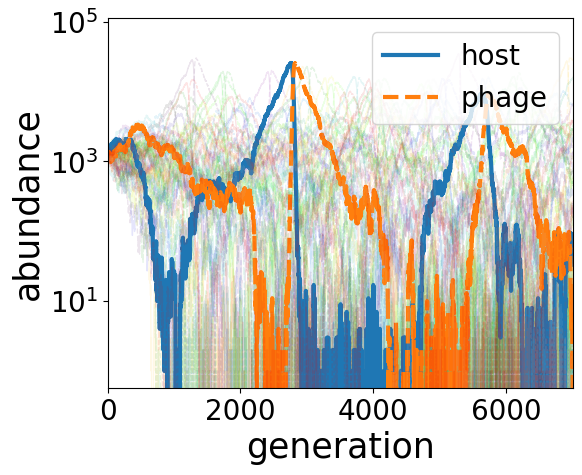

In [4]:
if r*N>=L^2/2
    suffix = "high"
elseif r*N>=L
    suffix = "weak"
else
    suffix = "extinction"
end
i = 1
g =6
count=1
t0 = 1
t1 = t0+size(TimeSeries_genotype_host, 1)-1

colors = plt.cm.nipy_spectral(LinRange(0,1,30))
fig, ax = plt.subplots(figsize=( 6, 4.8))
for (k, v) in dict_genenotype2index
    if count<=30 && g in k
        #println(count)
        fig.patch.set_visible(false)
        if count == 24
            alpha =1
            c1 = "tab:blue"
            c2 = "tab:orange"
            width =3
            ax.plot(1:t1-t0+1, TimeSeries_genotype_host[t0:t1, v], label="host",linewidth =width, alpha = alpha, color= c1)
            ax.plot(1:t1-t0+1, TimeSeries_genotype_phage[t0:t1, v], color= c2,linewidth =width, alpha = alpha, linestyle="dashed", label="phage")
        else
            alpha = 0.1
            c1 = colors[count,:]
            c2 = colors[count,:]
            width =1
            ax.plot(1:t1-t0+1, TimeSeries_genotype_host[t0:t1, v],linewidth =width, alpha = alpha, color= c1)
            ax.plot(1:t1-t0+1, TimeSeries_genotype_phage[t0:t1, v], color= c2,linewidth =width, alpha = alpha, linestyle="dashed")
        end
        #ax.set_xlim([1*10^4, 1.4*10^4])
        #ax.set_xlim([50000, 50500])
        ax.set_xlim(0, 7000)
        count = count + 1
    end
end
plt.tick_params(axis="both", which="major", labelsize=20)
#ax.set_xticks(ax.get_xticks()[1:2:end])
#ax.plot(1:t1-t0+1, TimeSeries_gene_host[t0:t1, g]/(L-1), linewidth =5, label="host")
ax.set_yscale("log")
#ax.axis("off")
plt.legend(fontsize=20, loc="upper right")
ax.set_xlabel("generation", fontsize=25)
ax.set_ylabel("abundance", fontsize=25)
fig.savefig("genotype_pairs_"*suffix*".pdf", dpi=150, bbox_inches="tight", transparent=true)

# Histogram of population abundances

## Genotype

6235.2042641109665
6636.8858371899305


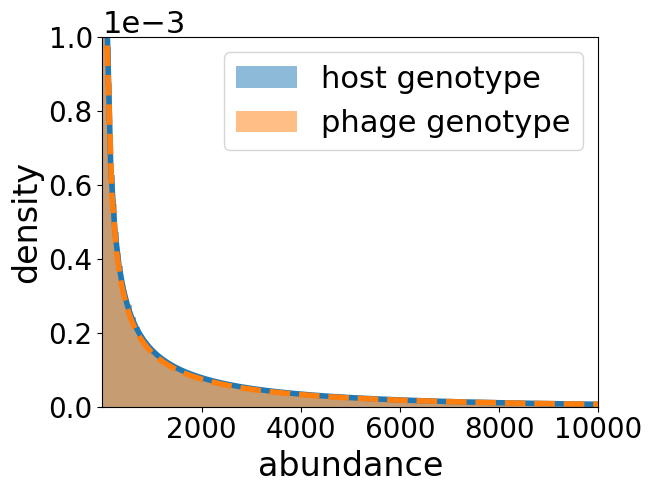

In [5]:
f_abs(x, xavg, theta) = x^(xavg/theta)*x^(-1)*exp(-x/theta)/((theta)^(xavg/theta)*gamma(xavg/theta))

t0, t1 = floor(Int64, size(TimeSeries_genotype_host, 1)/10), size(TimeSeries_genotype_host, 1)
data = vec(TimeSeries_genotype_host[t0:t1, :])

data = data[data .>0]
theta_GH = mean((vec(data) .- mean(data)).^2 ./mean(data))
println(theta_GH)

xavg = mean(data)
(n2, bins2, patches) = plt.hist(data,bins = 900, density = true, color="tab:blue", alpha=0.5, label="host genotype");
x = bins2[2:end]
plt.plot(x, f_abs.(x,xavg, theta_GH), color="tab:blue", linewidth=4)#,label=L"$\Theta$="*@sprintf("%.1f", theta_GH),linewidth=3)

data = vec(TimeSeries_genotype_phage[t0:t1, :])
data = data[data .>0]
theta_GP = mean((vec(data) .- mean(data)).^2 ./mean(data))
println(theta_GP)
xavg = mean(data)
(n2, bins2, patches) = plt.hist(data,bins = 900, density = true, color="tab:orange", alpha=0.5, label="phage genotype");
x = bins2[2:end]
plt.plot(x, f_abs.(x,xavg, theta_GP), linestyle="dashed", color="tab:orange", linewidth=4) #,label=L"$\Theta$="*@sprintf("%.1f", theta_GP),linewidth=3)
plt.xlabel("abundance", fontsize =24)
plt.ylabel("density", fontsize =24)
plt.xlim(left=0)
plt.xlim([1,10000])
plt.ylim([0,0.001])
plt.ticklabel_format(axis="y", style="sci", scilimits=[0,0])
plt.tick_params(axis="both", which="major", labelsize=20)
ax = plt.gca()
ax.yaxis.offsetText.set(size=22)
plt.legend(fontsize=22)
plt.savefig("GenotypeDist_"*suffix*".pdf", dpi=150, bbox_inches="tight")

## Gene

6070.50592892157
6575.768418029867
6575.768418029867


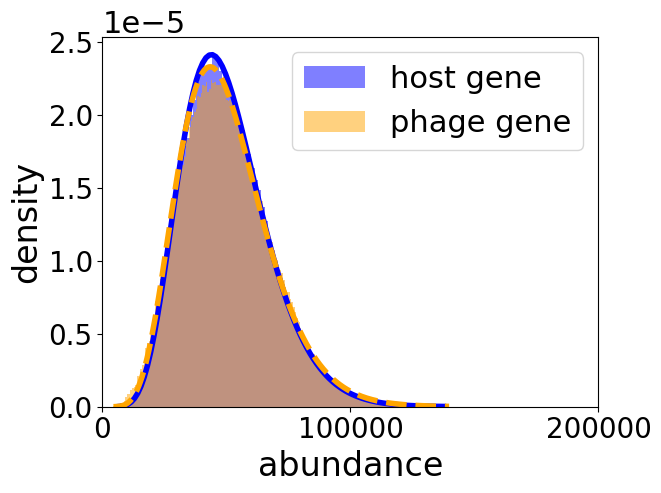

In [6]:
f_abs(x, xavg, theta) = (x/theta)^(xavg/theta)/x*exp(-x/theta)/gamma(xavg/theta)
#f_abs(x, xavg, theta) = x^(xavg/theta)*x^(-1)*exp(-x/theta)/((theta)^(xavg/theta)*gamma(xavg/theta))
t0, t1 = floor(Int64, size(TimeSeries_gene_host, 1)*5/10), size(TimeSeries_gene_host, 1)


data = vec(TimeSeries_gene_host[t0:t1, :])
theta = mean((data .- mean(data)).^2 ./mean(data))
println(theta)
#theta = 1/2/r
#println(theta)
(n2, bins2, patches) = plt.hist(data, bins =100,color="blue", density = true, alpha=0.5,label="host gene");
plt.plot(bins2, f_abs.(bins2, mean(data), theta),color="blue", linewidth=4)#label=L"$\theta$="*@sprintf("%.1f", theta))

data = vec(TimeSeries_gene_phage[t0:t1, :])
data = data[data.>0]
theta = mean((data .- mean(data)).^2 ./mean(data))

println(theta)
println(theta)
(n2, bins2, patches) = plt.hist(data, bins =200,color="orange", density = true, alpha=0.5,label="phage gene");
plt.plot(bins2, f_abs.(bins2, mean(data), theta), linestyle="dashed",color="orange", linewidth=4),#label=L"$\theta$="*@sprintf("%.1f", theta))


#title = args2title(title_args)
plt.xlabel("abundance",fontsize=24)
plt.ylabel("density",fontsize=24)
plt.xlim(left=1)
plt.xticks(0:100000:250000)
plt.ticklabel_format(axis="y", style="sci", scilimits=[0,0])
plt.tick_params(axis="both", which="major", labelsize=20)
ax = plt.gca()
ax.yaxis.offsetText.set(size=22)
plt.legend(fontsize=22)
plt.savefig("GeneDist_"*suffix*".pdf", dpi=150, bbox_inches="tight")

# Boom-bust cycles

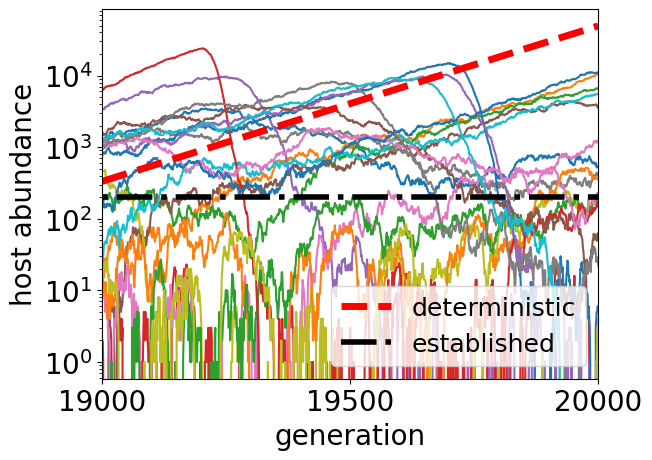

In [17]:
t0 = 2*10^4-1000
t1 = 2*10^4 
plt.plot(t0:t1, TimeSeries_genotype_host[t0:t1, 100:20+100])
plt.plot(t0:t1, 333 .*exp.(s.*(0:t1-t0)), color="r", linestyle ="dashed", linewidth = 5,label="deterministic")
plt.hlines(y=2/(2*s), xmin=0, xmax=1e5, color="black", linestyle ="-.",label = "established", linewidth=4)
#plt.hlines(y=2*N/(L*(L-1)), xmin=0, xmax=1e5, color="black", linestyle ="-.",label = "mean", linewidth=4)
plt.xlim([t0, t1])
plt.tick_params(axis="both", which="major", labelsize=20)
#plt.ylim([1, 15*maximum(dataY)])
plt.yscale("log")
plt.xlabel("generation",fontsize = 20)
plt.ylabel("host abundance",fontsize = 20)
plt.legend(fontsize=18)
plt.xticks(t0:500:t1)
plt.savefig("manypairsHost.pdf", dpi=150, bbox_inches="tight")

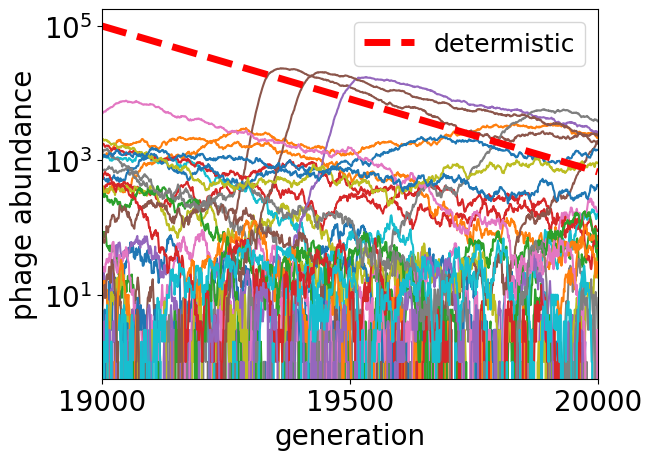

In [19]:
t0 = 2*10^4-1000
t1 = 2*10^4  
plt.plot(t0:t1, TimeSeries_genotype_phage[t0:t1, 50:30+50])
plt.plot(t0:t1, 10^5 .*exp.(-s .*(0:t1-t0)), color="r", linestyle ="dashed", linewidth = 5,label="determistic")
#plt.hlines(y=2/0.0022419671099050825, xmin=0, xmax=1e5, color="black", linestyle ="-.",label = "established", linewidth=4)
#plt.hlines(y=2*N/(L*(L-1)), xmin=0, xmax=1e5, color="black", linestyle ="-.",label = "mean", linewidth=4)
plt.xlim([t0, t1])
plt.tick_params(axis="both", which="major", labelsize=20)
#plt.ylim([1, 15*maximum(dataY)])
plt.yscale("log")
plt.xlabel("generation",fontsize = 20)
plt.ylabel("phage abundance",fontsize = 20)
plt.legend(fontsize=18)
plt.xticks(t0:500:t1)
plt.savefig("manypairsHost.pdf", dpi=150, bbox_inches="tight")

# Host clone size whe the phage gets estabished

6780.251091055464


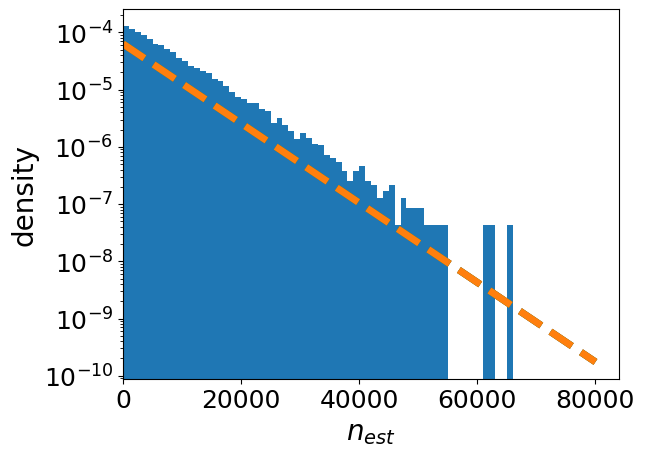

In [11]:
estab_size = find_establishment_size(TimeSeries_genotype_host, TimeSeries_genotype_phage)
println(mean(estab_size))
plt.hist(estab_size, bins=0:1000:8*10^4, density=true)
plt.yscale("log")
plt.xlim(left=0)
plt.ylabel("density", fontsize=20)
plt.xlabel(L"$n_{est}$", fontsize=20)
plt.plot(0:1000:8*10^4, 10^-4.2 .* exp.(-collect(0:1000:8*10^4).*((1+args["rprop"])*r)), color="tab:red", linewidth=5, linestyle="dashed")
plt.plot(0:1000:8*10^4, 10^-4.2 .* exp.(-collect(0:1000:8*10^4).*((2*args["rprop"])*r)), color="tab:green", linewidth=5, linestyle="dashed")
plt.plot(0:1000:8*10^4, 10^-4.2 .* exp.(-collect(0:1000:8*10^4).*((2)*r)), color="tab:orange", linewidth=5, linestyle="dashed")
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.xticks(0:2*10^4:8*10^4)
plt.savefig("host_est_size.pdf", dpi=150, bbox_inches="tight", transparent=true)